# Tiny BERT

BERT (Bidirectional Encoder Representations from Transformers) is a **Transformer Encoder**. That is, it is built using only the Encoder part of the Transformer.

Note that, just like the Encoder in the Transformer architecture, BERT is bidirectional: it reads the entire sequence at once, allowing every word to "see" every other word in both directions.
In concrete terms, this means not masking the attention (which instead happens in the Decoder).

### Architecture
- **Embedding**
    - **Token Embedding**: vector representation of each token meaning
    - **Positional Embedding**: a vector representation of the position of each token (that is learned in BERT)
- **Multi-Head Self-Attention**: attention mechanism used to learn the mutual relevance of tokens within a sequence
- **Feed-Formard Network**
- **Residual connections** and **Layer normalization** procedures

### Special Tokens

BERT uses two special tokens:
- `[SEP]`: Since BERT is trained to work with two sentences, but without a "decoding" part, the two sequences have to be concatenated. In order to distinguish where the first sentence ends and the second one begins, the special token `[SEP]` is used. Note that, together with this special token, this concatenation implies the usage of another "layer" of embedding: the Segment Embeddings. Values are 0 for tokens in the first sentence and 1 for tokens in the second sentence.
- `[CLS]`: Generally, the goal of BERT is to embed the meaning of a whole sequence. In order to do so, we need a special place where we can put this embedding (as replacing it with one of the tokens of the actual sentence wouldn't make much sense). For this reason, we add a special token at the start `[CLS]`, in which the model learns to encode the meaning of the entire sentence. **Note**: the model does not know a-priori to put the embedding here, but if we use this value to compute the loss during training, it will eventually figure it out.

### Training tasks

The idea of BERT is to **look at all the tokens at the same time**, not left-to-right and then right-to-left. However, this is not compatible with the standard training task of predicting the next token. For this reason, BERT is pre-trained in a semi-supervised manner on these two tasks:

1. **Masked Language Model (MLM)**: from a corpus of real sentences, some words per sentence are asked with a special token `[MASK]`. Then, BERT is trained to predict the masked token.
2. **Next Sentence Prediction (NSP)**: BERT is trained with a dataset of pairs of sentences `A` and `B`. In half of the pairs, `B` is the correct continuation of `A` (the real next sentence in the corpus' document). In the other half, `B` is a random sentence from the corpus. The goal of BERT is to predict whether a sentence `B` is the next sentence with respect to a previous sentence `A`.

We assume that a model that performs well in both MLM and NSP has learned rich word-level and sentence-level representations correctly (as both tasks are something in which an educated human would perform very well). The pre-trained BERT model can then be fine-tuned on specific tasks, with very little task-specific architecture.

 ## Toy Task

We use a Vocabulary of emojis. The corpus is a list of sentences (sequences of emojis) with a semantical meaning associated to them. On this corpus, we can perform both **MLM** and **NSP** tasks.

We choose this task as it uses a very small vocabulary size (V = 14, the number of emojis), which makes the learning much less costly.

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import random
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
config = {
    "vocab_size": 14,  # V: 5 special + 9 emojis
    "hidden_size": 8,  # d_model: The main vector size (758 for real BERT)
    "max_position_embeddings": 16,  # max_len: Longest possible sequence (512 for real BERT)
    "type_vocab_size": 2,  # 0 for Sentence A, 1 for Sentence B
    "hidden_dropout_prob": 0.1,  # Standard BERT dropout
    "attention_heads": 1,  # (12 for real BERT)
    "attention_dropout_prob": 0.1,
    "intermediate_size": 32,  # Should be hidden_size * 4
    "hidden_act": "gelu",
    "num_hidden_layers": 2 # (12 for real BERT)
}

TOKEN_TO_ID = {
    '[PAD]': 0,
    '[UNK]': 1,
    '[CLS]': 2,
    '[SEP]': 3,
    '[MASK]': 4,
    '☀️': 5,
    '🌙': 6,
    '🧑': 7,
    '☕': 8,
    '🥐': 9,
    '💻': 10,
    '🏃': 11,
    '📖': 12,
    '😴': 13,
}

ID_TO_TOKEN = {id: token for token, id in TOKEN_TO_ID.items()}
TOKEN_TO_TEXT = {
    '[PAD]': '[PAD]',
    '[UNK]': '[UNK]',
    '[CLS]': '[CLS]',
    '[SEP]': '[SEP]',
    '[MASK]': '[MASK]',
    '☀️': 'day',
    '🌙': 'night',
    '🧑': 'person',
    '☕': 'coffee',
    '🥐': 'food',
    '💻': 'work',
    '🏃': 'run',
    '📖': 'book',
    '😴': 'sleep',
}

In [3]:
def tokenize(sentence, vocab_map):
    """Converts a string of emojis into a list of token IDs."""
    tokens = sentence.split(' ')  # Real BERT applies WordPiece instead of just splitting
    return [vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]


def create_segment_ids(token_ids, sep_id):
    """
    Generates the list of segment IDs (0s and 1s) from a list of token IDs.
    All tokens *before and including* the first [SEP] are segment 0.
    All tokens *after* the first [SEP] are segment 1.
    """
    segment_ids = []
    current_segment = 0
    for token_id in token_ids:
        segment_ids.append(current_segment)
        # If this is the first [SEP] token, flip to segment 1
        if token_id == sep_id and current_segment == 0:
            current_segment = 1
    return segment_ids

In [4]:
# Example of tokenization

sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"

print("TOKENIZATION")

print("Tokens to IDs")
print(f"First sentence: {tokenize(sentence_a, TOKEN_TO_ID)}")
print(f"Second sentence: {tokenize(sentence_b, TOKEN_TO_ID)}")

bert_real_input = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

print("BERT real input")
print(bert_real_input)
tokens = tokenize(bert_real_input, TOKEN_TO_ID)
print(f"Full tokens to IDs: {tokens}")
token_type_ids = create_segment_ids(tokens, sep_id=TOKEN_TO_ID['[SEP]'])
print(f"Token types: {token_type_ids}")

TOKENIZATION
Tokens to IDs
First sentence: [5, 7, 11]
Second sentence: [7, 8, 9]
BERT real input
[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 [SEP]
Full tokens to IDs: [2, 5, 7, 11, 3, 7, 8, 9, 3]
Token types: [0, 0, 0, 0, 0, 1, 1, 1, 1]


In [6]:
class BertEmbeddings(nn.Module):
    """
    Constructs the BERT input embeddings.

    BERT Embeddings are the sum of:
    1. Token Embeddings (Word Embeddings)
    2. Position Embeddings
    3. Segment Embeddings (Token Type Embeddings) to check if a token is in the first or second segment
    """

    def __init__(self, config):
        super().__init__()

        # 1. Token Embeddings
        # A lookup table for our 14-token vocabulary.
        # padding_idx=0 tells nn.Embedding to treat token ID 0 as "padding".
        # Its vector will be all zeros and will not be updated during training.
        self.word_embeddings = nn.Embedding(
            config["vocab_size"],
            config["hidden_size"],
            padding_idx=0
        )

        # 2. Position Embeddings
        # A lookup table for all possible positions (0 to 15).
        # This is a learned representation of *where* a token is.
        self.position_embeddings = nn.Embedding(
            config["max_position_embeddings"],
            config["hidden_size"]
        )

        # 3. Segment (Token Type) Embeddings
        # A lookup table for the sentence type (0 or 1).
        # This is how the model distinguishes Sentence A from Sentence B.
        self.token_type_embeddings = nn.Embedding(
            config["type_vocab_size"],
            config["hidden_size"]
        )

        # --- Post-processing ---
        # We apply Layer Normalization and Dropout *after* summing.
        # This is a standard part of the BERT architecture.
        # LayerNorm stabilizes the values, dropout prevents overfitting.
        # eps=1e-12 is from the paper. we use 1e-5
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, input_ids, token_type_ids):
        """
        Forward pass for the embeddings.

        Args:
            input_ids (torch.Tensor): Shape (batch_size, seq_length).
                                      The token IDs.
            token_type_ids (torch.Tensor): Shape (batch_size, seq_length).
                                           The segment IDs (0s and 1s).

        Returns:
            torch.Tensor: Shape (batch_size, seq_length, hidden_size).
                          The final input embeddings.
        """
        # --- 1. Get Token Embeddings ---
        # input_ids shape: (batch_size, seq_len)
        # words_embeddings shape: (batch_size, seq_len, hidden_size)
        words_embeddings = self.word_embeddings(input_ids)

        # --- 2. Get Segment Embeddings ---
        # token_type_ids shape: (batch_size, seq_len)
        # token_type_embeddings shape: (batch_size, seq_len, hidden_size)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # --- 3. Get Position Embeddings ---
        # We need to create the position IDs on the fly.
        # If input_ids is (batch, 9), we need position_ids (batch, 9)
        # that looks like [[0, 1, 2, 3, 4, 5, 6, 7, 8]]

        # Get the sequence length: e.g., 9
        seq_length = input_ids.size(1)

        # Create a tensor of [0, 1, 2, ..., seq_length-1]
        # shape: (seq_length)
        position_ids = torch.arange(
            seq_length,
            dtype=torch.long,
            device=input_ids.device
        )

        # Make it (1, seq_length) and expand it to match the batch size
        # shape: (batch_size, seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # Look up the position embeddings
        # shape: (batch_size, seq_len, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)

        # --- Create the final embeddings ---
        # Add all three embedding vectors together element-wise.
        embeddings = words_embeddings + position_embeddings + token_type_embeddings

        # --- Post-processing ---
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [7]:
# Example of Embedding (not trained, so meaningless)
# Notice that the same token 🧑 is embedded in different ways thanks to position and segment

sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐 🏃 ☕"

input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(f"Input string: {input_string}")

token_ids = tokenize(input_string, TOKEN_TO_ID)
# Convert to a PyTorch tensor (batch_size = 1)
# shape: (1, 9)
input_ids = torch.tensor([token_ids])

print(f"Input IDs:    {input_ids}")

# 3. Create the Segment IDs
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

print(f"Input IDs shape:        {input_ids.shape}")
print(f"Token Type IDs shape: {token_type_ids.shape}")

embedding_module = BertEmbeddings(config)
embedding_module.eval()
with torch.no_grad():
    output_embeddings = embedding_module(input_ids, token_type_ids)

# 11 is the number of tokens, 8 is the size of each embedding
print(f"\nOutput embeddings shape: {output_embeddings.shape}")
print("\nEmbeddings\n")
print(output_embeddings[0])

Input string: [CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input IDs:    tensor([[ 2,  5,  7, 11,  3,  7,  8,  9, 11,  8,  3]])
Input IDs shape:        torch.Size([1, 11])
Token Type IDs shape: torch.Size([11])

Output embeddings shape: torch.Size([1, 11, 8])

Embeddings

tensor([[ 8.0065e-01, -1.2538e+00,  2.8021e-02, -1.0897e+00,  9.9084e-01,
          7.8739e-02,  1.5477e+00, -1.1024e+00],
        [-8.6853e-01,  2.3552e-01,  1.1784e+00, -3.0562e-03,  1.9142e+00,
         -5.5726e-01, -8.4154e-01, -1.0577e+00],
        [-4.7423e-01,  9.1841e-01,  1.9567e+00,  3.9031e-01, -3.4045e-02,
         -7.1861e-01, -5.9784e-01, -1.4407e+00],
        [ 4.8537e-01,  7.3178e-02,  1.1629e+00, -7.1744e-01,  1.6135e+00,
         -9.7543e-01, -1.1783e-01, -1.5242e+00],
        [ 1.7146e+00,  7.7802e-01,  3.7618e-01, -1.5329e+00,  5.1931e-01,
         -1.0628e+00, -4.2288e-02, -7.5005e-01],
        [-5.2820e-01,  2.1345e+00, -1.4926e-04, -1.5331e+00, -1.3379e-02,
          4.7536e-01,  2.0423e-01, -7.3931e-01],

In [8]:
# Self-Attention is basically a way to represent a token as the weighted average of all the other tokens.
# This way, the meaning of the token embeds its context

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config['attention_heads']
        self.dropout_prob = config['attention_dropout_prob']
        self.hidden_size = config['hidden_size']

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError("The hidden size is not a multiple of the number of attention heads")

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)

        # In a multi-head setup, all_head_size would be (num_heads * head_size).
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # --- The 3 Linear Layers ---
        # These project the input embeddings (d_model=8) into Q, K, and V.
        self.Q = nn.Linear(self.hidden_size, self.all_head_size)
        self.K = nn.Linear(self.hidden_size, self.all_head_size)
        self.V = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (This is the output from our BertEmbeddings)

        Returns:
            context_layer (torch.Tensor): Shape (batch_size, seq_length, hidden_size)
                                          (The context-aware embeddings)
            attention_probs (torch.Tensor): Shape (batch_size, num_heads, seq_length, seq_length)
                                            (The attention weights, for visualization)
        """

        # 1. Project to Q, K, V
        Q = self.Q(hidden_states)
        K = self.K(hidden_states)
        V = self.V(hidden_states)

        # NOTE: In a *multi-head* setup, we would now split (batch, seq_len, 8)
        # into (batch, num_heads, seq_len, head_size).
        # Since num_heads=1, we can just add a "dummy" head dimension.
        # Q: (batch, 1, seq_len, 8)
        Q = Q.view(Q.size(0), Q.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # 2. Calculate Attention Scores (Q @ K.T)
        attention_scores = torch.matmul(Q, K.transpose(-1, -2))

        # 3. Scale the scores
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # 4. Apply Softmax to get probabilities
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # Apply dropout to the probabilities
        attention_probs = self.dropout(attention_probs)

        # 5. Get Weighted Sum of Values (Weights @ V)
        context_layer = torch.matmul(attention_probs, V)

        # NOTE: In a *multi-head* setup, we'd now "un-split" the heads:
        # 1. Transpose: (batch, seq_len, num_heads, head_size)
        # 2. Reshape:  (batch, seq_len, all_head_size)
        # We do it here just to be architecturally correct.
        context_layer = context_layer.transpose(1, 2).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # We return both the final vectors and the attention weights
        return context_layer, attention_probs

    @staticmethod
    def plot_attention_heatmap(attention_matrix, token_ids, head_index=0, batch_item=0):
        matrix = attention_matrix[batch_item, head_index].to('cpu').detach().numpy()
        tokens = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
        seq_len = len(tokens)

        fig, ax = plt.subplots(figsize=(9, 5 * attention_matrix.shape[0]))
        im = ax.imshow(matrix, cmap='Reds')

        ax.set_xticks(np.arange(seq_len))
        ax.set_yticks(np.arange(seq_len))
        ax.set_xticklabels(tokens)
        ax.set_yticklabels(tokens)

        # The Y-axis is the "Query" (the token *doing* the looking)
        # The X-axis is the "Key" (the token *being* looked at)
        ax.set_ylabel("Query (Token 'looking')")
        ax.set_xlabel("Key (Token 'being looked at')")
        ax.set_title(f"Attention Weights (Head {head_index})")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        threshold = matrix.max() * 0.6
        for i in range(seq_len):
            for j in range(seq_len):
                val = matrix[i, j]
                color = "white" if val < threshold else "black"
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color)

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        plt.show()

[CLS] ☀️ 🧑 🏃 [SEP] 🧑 ☕ 🥐 🏃 ☕ [SEP]
Input embeddings shape: torch.Size([1, 11, 8])

Context Vectors shape:  torch.Size([1, 11, 8])
Attention Matrix shape: torch.Size([1, 1, 11, 11])


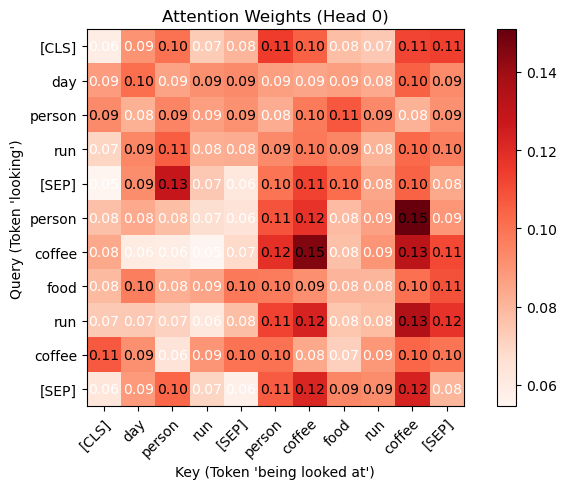

In [9]:
# Example of Attention (again, not trained so meaningless)

input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"
print(input_string)
token_ids = tokenize(input_string, TOKEN_TO_ID)
input_ids = torch.tensor([token_ids])
token_type_ids = torch.tensor(
    create_segment_ids(token_ids, sep_id=TOKEN_TO_ID['[SEP]'])
)

embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

print(f"Input embeddings shape: {input_embeddings.shape}")

attention_module = SelfAttention(config=config)
attention_module.eval()
with torch.no_grad():
    context_vectors, attention = attention_module(input_embeddings)

print(f"\nContext Vectors shape:  {context_vectors.shape}")
print(f"Attention Matrix shape: {attention.shape}")
SelfAttention.plot_attention_heatmap(attention_matrix=attention, token_ids=token_ids)

In [10]:
class BertSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attention_module = SelfAttention(config)
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, hidden_states):
        context_vectors, attention_probs = self.attention_module(hidden_states)
        attention_output = self.dense(context_vectors)
        attention_output = self.dropout(attention_output)
        return attention_output, attention_probs


class BertAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.self_attention = BertSelfAttention(config)
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        attention_output, attention_probs = self.self_attention(hidden_states)
        # The "Add & Norm" step:
        # hidden_states is the *original input* to this block
        summed_output = attention_output + hidden_states # "Add"
        normed_output = self.LayerNorm(summed_output) # "Norm"
        return normed_output, attention_probs

In [11]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["intermediate_size"])
        if config["hidden_act"] == "gelu":
            self.intermediate_act_fn = nn.GELU()
        else:
            self.intermediate_act_fn = nn.ReLU()

    def forward(self, hidden_states):
        dense_output = self.dense(hidden_states)
        activated_output = self.intermediate_act_fn(dense_output)
        return activated_output


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, intermediate_output, attention_output):
        dense_output = self.dense(intermediate_output)
        dropped_output = self.dropout(dense_output)
        # The *second* "Add & Norm" step
        # 1. Add the residual (from the *output* of the attention layer)
        # 2. Apply Layer Normalization
        summed_output = dropped_output + attention_output
        normed_output = self.LayerNorm(summed_output)
        return normed_output

In [12]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, return_attention_output=False):
        """
        Args:
            hidden_states (torch.Tensor): (batch, seq_len, 8)

        Returns:
            layer_output (torch.Tensor): (batch, seq_len, 8)
            attention_probs (torch.Tensor): (batch, 1, seq_len, seq_len)
        """

        attention_output, attention_probs = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        if return_attention_output:
            return layer_output, attention_probs, attention_output
        else:
            return layer_output, attention_probs

In [13]:
def token_journey(matrixes, token_ids, titles, sleep_time=1):
    token_names = [TOKEN_TO_TEXT[ID_TO_TOKEN[t]] for t in token_ids]
    for i, matrix in enumerate(matrixes):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, .6 * matrix.shape[0]))
        ax.set_title(titles[i])
        ax.imshow(matrix, cmap='Reds', aspect='auto')
        ax.set_xticks(np.arange(matrix.shape[1]))
        ax.set_xticklabels(np.arange(matrix.shape[1]))
        ax.set_yticks(np.arange(len(token_names)))
        ax.set_yticklabels(token_names)
        plt.tight_layout()
        plt.show()
        time.sleep(sleep_time)


In [14]:
sentence_a = "☀️ 🧑 🏃"
sentence_b = "🧑 ☕ 🥐"
input_string = f"[CLS] {sentence_a} [SEP] {sentence_b} [SEP]"

TOKEN_TO_TRACK = "🥐"
TOKEN_NAME = TOKEN_TO_TEXT[TOKEN_TO_TRACK]
TRACKED_TOKEN_INDEX = input_string.split(' ').index(TOKEN_TO_TRACK)
print(f"Tracking token '{TOKEN_TO_TRACK}' at index {TRACKED_TOKEN_INDEX}")

# --- 1. Get Token & Segment IDs ---
token_id_list = tokenize(input_string, TOKEN_TO_ID)
segment_id_list = create_segment_ids(token_id_list, TOKEN_TO_ID['[SEP]'])
input_ids = torch.tensor([token_id_list])
token_type_ids = torch.tensor([segment_id_list])

# --- 2. Run Module 1 (Embeddings) ---
embedding_module = BertEmbeddings(config)
embedding_module.eval()
with torch.no_grad():
    input_embeddings = embedding_module(input_ids, token_type_ids)

# --- 3. Run Module 3 (BertLayer) ---
bert_layer = BertLayer(config)
bert_layer.eval()
with torch.no_grad():
    layer_output, attention_scores, attention_output = bert_layer(
        input_embeddings, return_attention_output=True
    )

# --- 4. Get the 3 "Pages" for our token ---
page1 = input_embeddings.squeeze(0)[TRACKED_TOKEN_INDEX]
page2 = attention_output.squeeze(0)[TRACKED_TOKEN_INDEX]
page3 = layer_output.squeeze(0)[TRACKED_TOKEN_INDEX]

print(f"Vector for '{TOKEN_TO_TRACK}' (Page 1): {page1.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 2): {page2.shape}")
print(f"Vector for '{TOKEN_TO_TRACK}' (Page 3): {page3.shape}")

Tracking token '🥐' at index 7
Vector for '🥐' (Page 1): torch.Size([8])
Vector for '🥐' (Page 2): torch.Size([8])
Vector for '🥐' (Page 3): torch.Size([8])


In [15]:
titles = ['Embbeding layer', 'Attention layer', 'Feed Forward layer']
token_journey([
    input_embeddings.squeeze(0),
    attention_output.squeeze(0),
    layer_output.squeeze(0)], token_ids=[int(x) for x in input_ids[0]],
    titles=titles, sleep_time=2)

In [16]:
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([
            BertLayer(config) for _ in range(config["num_hidden_layers"])
        ])

    def forward(self, hidden_states, output_all_layers=True):
        all_hidden_states = ()
        all_attentions = ()

        for layer_module in self.layer:
            if output_all_layers:
                all_hidden_states = all_hidden_states + (hidden_states,)
            hidden_states, attention_probs = layer_module(hidden_states)
            if output_all_layers:
                all_attentions = all_attentions + (attention_probs,)
        if output_all_layers:
            all_hidden_states = all_hidden_states + (hidden_states,)
        return all_hidden_states, all_attentions

In [17]:
class BertPooler(nn.Module):
    """
    BertPooler is needed for the "pooling" of the [CLS] token.
    This special token is where the Bert Encoder embeds the meaning of the entire sentence.

    But how do we force the network to put the whole meaning in this special token?
    By extracting this embedding and use it for the classification task.
    In order to perform well, the network is forced to put the meaning of the sentence in the [CLS] token
    """
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We just grab the vector for the *first token* ([CLS])
        first_token_tensor = hidden_states[:, 0]
        # Pass it through the dense layer and activation
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [18]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids):
        embedding_output = self.embeddings(input_ids, token_type_ids)
        all_hidden_states, all_attentions = self.encoder(embedding_output)
        sequence_output = all_hidden_states[-1]
        pooled_output = self.pooler(sequence_output)
        # We return the last layer's vectors and the [CLS] vector
        # Just for demo purposes, we get also all the attentions
        # (We can add all_hidden_states/all_attentions later if needed)
        return sequence_output, pooled_output, all_attentions

In [19]:
# At this point we have a fully working (untrained) BERT architecture

tiny_bert_model = BertModel(config)
tiny_bert_model.eval()

with torch.no_grad():
    sequence_output, pooled_output, attentions = tiny_bert_model(input_ids, token_type_ids)

print("--- Output from full BertModel ---")
print(f"Final Sequence Output shape: {sequence_output.shape}")
print(f"Final Pooled Output shape:   {pooled_output.shape}")

print("\n--- Pooled Output Vector ([CLS] token) ---")
print(pooled_output)

--- Output from full BertModel ---
Final Sequence Output shape: torch.Size([1, 9, 8])
Final Pooled Output shape:   torch.Size([1, 8])

--- Pooled Output Vector ([CLS] token) ---
tensor([[ 0.4346,  0.1176, -0.1390,  0.6749,  0.0143, -0.5316, -0.0778, -0.0787]])


## BERT Training

In order to train BERT on the two tasks we previously presented (NSP and MLM) we have to do an extra step in the BERT Architecture:
* BERT would simply provide the embedding for the sentence (for each token and the full sentence)
* For the NSP task, we need to transform this embedding into a vector of size 2, which states the probabilities of IsNext and NotNext.
* For the MLM task, we need to transform this embedding into a probability distribution that "guesses" the masked token (note that we have one embedding for each token, so we apply the transformation on each token's embedding and then we consider that of only the masked tokens).

In [32]:
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        if config["hidden_act"] == "gelu":
            self.transform_act_fn = nn.GELU()
        else:
            self.transform_act_fn = nn.ReLU()
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class BertMLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)
        # The "decoder" layer that maps 8 -> 14
        # Note: We set bias=False because we'll add it manually.
        self.decoder = nn.Linear(config["hidden_size"], config["vocab_size"], bias=False)

        # We add the bias as a separate parameter
        self.bias = nn.Parameter(torch.zeros(config["vocab_size"]))

        # Manually set the decoder's bias to our new parameter
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states

In [41]:
class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.mlm_head = BertMLMPredictionHead(config)  # For the MLM task
        self.nsp_classifier = nn.Linear(config["hidden_size"], 2) # For the NSP task
        self.tie_weights()

    def tie_weights(self):
        """
        Tie the weights between the token embeddings and the MLM decoder.
        This is a *critical* part of the BERT design.

        What we mean by "tying" is that we want to use the same embedding for both the encoding and the decoding.
        This reduces the number of parameters and does not require the model to "re-learn" the connection between
        embeddings and logits.

        In BERT we have the Embedding: from vocab_size to hidden_size
        Here we have the Decoding: from hidden_size to vocab_size
        """
        # Get the weight matrix from our embedding layer (Module 1)
        embedding_weights = self.bert.embeddings.word_embeddings.weight

        # Set the MLM decoder's weight to be the *same* matrix
        self.mlm_head.decoder.weight = embedding_weights

        # And make sure the bias is still our learned 'self.mlm_head.bias'
        self.mlm_head.decoder.bias = self.mlm_head.bias

    def forward(self, input_ids, token_type_ids, attention_mask):
        sequence_output, pooled_output, attentions = self.bert(
            input_ids, token_type_ids, attention_mask)
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_classifier(pooled_output)
        return mlm_logits, nsp_logits, attentions

In [42]:
# Small example of our training process

final_model = BertForPreTraining(config)
final_model.eval()

print("--- Checking Weight Tying ---")
# Get memory addresses
emb_weights_ptr = final_model.bert.embeddings.word_embeddings.weight.data_ptr()
dec_weights_ptr = final_model.mlm_head.decoder.weight.data_ptr()

print(f"Embedding Weight Pointer: {emb_weights_ptr}")
print(f"Decoder Weight Pointer:   {dec_weights_ptr}")
print(f"Weights are tied:         {emb_weights_ptr == dec_weights_ptr}")

with torch.no_grad():
    mlm_logits, nsp_logits, attentions = final_model(input_ids, token_type_ids)

print("\n--- Final Logit Output Shapes ---")
print(f"MLM Logits shape: {mlm_logits.shape}")
print(f"NSP Logits shape: {nsp_logits.shape}")

print("\n--- MLM Logits (for token 1) ---")
# The scores for the 14 vocab words for the 2nd token ('☀️')
print(mlm_logits[0, 1, :])

print("\n--- NSP Logits ([CLS] token) ---")
# The scores for 'IsNext' and 'NotNext'
print(nsp_logits[0, :])

--- Checking Weight Tying ---
Embedding Weight Pointer: 4425187920064
Decoder Weight Pointer:   4425187920064
Weights are tied:         True


TypeError: BertForPreTraining.forward() missing 1 required positional argument: 'attention_mask'

### Dataset & Data Loader

In [36]:
# First we define the DATASET

MAX_LEN = 16

EMOJI_CORPUS = [
    # Doc 1: "The Productive Morning" (Our old Doc 1)
    [
        "☀️ 🧑 🏃",
        "🧑 ☕ 🥐",
        "🧑 💻"
    ],

    # Doc 2: "The Standard Evening" (Our old Doc 2)
    [
        "🌙 🧑 📖",
        "🧑 😴"
    ],

    # Doc 3: "The Coder's Morning"
    [
        "☀️ 🧑 ☕ 💻",    # Starts with coffee and code
        "🧑 💻",
        "🧑 ☕ 💻",    # More coffee, more code
        "🧑 🥐",          # Quick snack
        "🧑 💻"
    ],

    # Doc 4: "The Athlete's Day"
    [
        "☀️ 🧑 🏃",
        "🧑 ☕",
        "🧑 💻",
        "🌙 🧑 🏃",    # A run in the evening, too!
        "🧑 😴"
    ],

    # Doc 5: "The Intense Study Day"
    [
        "☀️ 🧑 📖",    # Starts by reading
        "🧑 ☕ 🥐",
        "🧑 💻 📖",    # Works AND reads
        "🌙 🧑 📖",
        "🧑 😴"
    ],

    # Doc 6: "The (Almost) Relaxing Day"
    [
        "☀️ 🧑 😴",    # Slept in late
        "🧑 🥐 ☕",
        "🧑 📖",
        "🌙 🧑 ☕ 📖",  # Evening coffee and a book
        "🧑 😴"
    ]
]


EMOJI_TOKENS = [
    token for token, idx in TOKEN_TO_ID.items()
    if idx > 4 # Skip [PAD], [UNK], [CLS], [SEP], [MASK]
]

In [43]:
# We are actually missing one piece before we can actually train: Attention Masking

# The idea is very simple: we do not want to pay attention to padding tokens

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config['attention_heads']
        self.dropout_prob = config['attention_dropout_prob']
        self.hidden_size = config['hidden_size']

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError("The hidden size is not a multiple of the number of attention heads")

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)

        # In a multi-head setup, all_head_size would be (num_heads * head_size).
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # --- The 3 Linear Layers ---
        # These project the input embeddings (d_model=8) into Q, K, and V.
        self.Q = nn.Linear(self.hidden_size, self.all_head_size)
        self.K = nn.Linear(self.hidden_size, self.all_head_size)
        self.V = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, hidden_states, attention_mask):
        Q = self.Q(hidden_states)
        K = self.K(hidden_states)
        V = self.V(hidden_states)

        Q = Q.view(Q.size(0), Q.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        K = K.view(K.size(0), K.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        V = V.view(V.size(0), V.size(1), self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        attention_scores = torch.matmul(Q, K.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Add the mask *before* the softmax.
        attention_scores = attention_scores + attention_mask

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, V)

        context_layer = context_layer.transpose(1, 2).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        return context_layer, attention_probs

class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention_module = SelfAttention(config)
        self.dense = nn.Linear(config["hidden_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, hidden_states, attention_mask):
        context_vectors, attention_probs = self.attention_module(hidden_states, attention_mask)
        attention_output = self.dense(context_vectors)
        attention_output = self.dropout(attention_output)
        return attention_output, attention_probs

class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = BertSelfAttention(config)
        self.LayerNorm = nn.LayerNorm(config["hidden_size"], eps=1e-5)

    def forward(self, hidden_states, attention_mask):
        attention_output, attention_probs = self.self_attention(
            hidden_states, attention_mask)
        # The "Add & Norm" step:
        # 1. Add the residual (skip) connection
        # 2. Apply Layer Normalization
        # hidden_states is the *original input* to this block
        summed_output = attention_output + hidden_states
        normed_output = self.LayerNorm(summed_output)
        return normed_output, attention_probs

class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask, return_attention_output=False):
        """
        Args:
            hidden_states (torch.Tensor): (batch, seq_len, 8)

        Returns:
            layer_output (torch.Tensor): (batch, seq_len, 8)
            attention_probs (torch.Tensor): (batch, 1, seq_len, seq_len)
        """

        attention_output, attention_probs = self.attention(
            hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        if return_attention_output:
            return layer_output, attention_probs, attention_output
        else:
            return layer_output, attention_probs

class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([
            BertLayer(config) for _ in range(config["num_hidden_layers"])
        ])

    def forward(self, hidden_states, attention_mask, output_all_layers=True):
        all_hidden_states = ()
        all_attentions = ()

        for layer_module in self.layer:
            if output_all_layers:
                all_hidden_states = all_hidden_states + (hidden_states,)
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            if output_all_layers:
                all_attentions = all_attentions + (attention_probs,)
        if output_all_layers:
            all_hidden_states = all_hidden_states + (hidden_states,)
        return all_hidden_states, all_attentions

class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids, attention_mask):
        embedding_output = self.embeddings(input_ids, token_type_ids)
        # We need to "extend" the 2D mask to 4D for the attention layers.
        # input attention_mask: (batch_size, seq_len)  e.g., [1, 1, 1, 0, 0]
        # 1. Add a head dimension: (batch_size, 1, seq_len)
        extended_attention_mask = attention_mask.unsqueeze(1)
        # 2. Add a query dimension: (batch_size, 1, 1, seq_len)
        extended_attention_mask = extended_attention_mask.unsqueeze(2)

        inverted_mask = 1.0 - extended_attention_mask.to(embedding_output.dtype)
        extended_attention_mask = inverted_mask * -10000.0

        all_hidden_states, all_attentions = self.encoder(
            embedding_output, attention_mask=extended_attention_mask)

        sequence_output = all_hidden_states[-1]
        pooled_output = self.pooler(sequence_output)
        # We return the last layer's vectors and the [CLS] vector
        # Just for demo purposes, we get also all the attentions
        # (We can add all_hidden_states/all_attentions later if needed)
        return sequence_output, pooled_output, all_attentions

class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.mlm_head = BertMLMPredictionHead(config)
        self.nsp_classifier = nn.Linear(config["hidden_size"], 2)
        self.tie_weights()

    def tie_weights(self):
        """
        Tie the weights between the token embeddings and the MLM decoder.
        This is a *critical* part of the BERT design.
        """
        # Get the weight matrix from our embedding layer (Module 1)
        embedding_weights = self.bert.embeddings.word_embeddings.weight

        # Set the MLM decoder's weight to be the *same* matrix
        self.mlm_head.decoder.weight = embedding_weights

        # And make sure the bias is still our learned 'self.mlm_head.bias'
        self.mlm_head.decoder.bias = self.mlm_head.bias

    def forward(self, input_ids, token_type_ids, attention_mask):
        sequence_output, pooled_output, attentions = self.bert(
            input_ids, token_type_ids, attention_mask)
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_classifier(pooled_output)
        return mlm_logits, nsp_logits, attentions

In [44]:
# Then we build a Dataset which can be given to a DataLoader.
# The Dataset already performs all transformations needed for the tasks to train on.

class BertPretrainingDataset(Dataset):
    """
    This dataset class generates masked token sequences and NSP pairs
    on-the-fly for BERT pre-training.
    Note that the two tasks are performed ON THE SAME PAIR, meaning that the tokens are masked from the concatenated pair.
    """
    def __init__(self, corpus, vocab_map, max_len):
        self.corpus = corpus
        self.vocab_map = vocab_map
        self.max_len = max_len
        self.vocab_keys = list(vocab_map.keys())
        self.special_tokens = {
            self.vocab_map['[PAD]'], self.vocab_map['[UNK]'],
            self.vocab_map['[CLS]'], self.vocab_map['[SEP]'],
            self.vocab_map['[MASK]']
        }
        self.emoji_token_ids = [vocab_map[t] for t in EMOJI_TOKENS]

    def __len__(self):
        # For a demo, we can just define a "virtual" length.
        # Each "epoch" will just be 1000 random samples.
        return 1000

    def __getitem__(self, index):
        # `index` is ignored; we just generate a random sample every time.

        # --- 1. Next Sentence Prediction (NSP) Task ---
        if random.random() < 0.5:
            # 50% chance: Get a TRUE "IsNext" pair
            sent_a_str, sent_b_str = self._get_next_sentence_pair()
            nsp_label = 0 # 0 = IsNext
        else:
            # 50% chance: Get a FALSE "NotNext" pair
            sent_a_str, sent_b_str = self._get_random_sentence_pair()
            nsp_label = 1 # 1 = NotNext

        # Tokenize A and B
        tokens_a = [self.vocab_map.get(t, self.vocab_map['[UNK]']) for t in sent_a_str.split(' ')]
        tokens_b = [self.vocab_map.get(t, self.vocab_map['[UNK]']) for t in sent_b_str.split(' ')]
        combined_tokens = [self.vocab_map['[CLS]']] + tokens_a + \
                          [self.vocab_map['[SEP]']] + tokens_b + \
                          [self.vocab_map['[SEP]']]

        # Build the Segment Embeddings (0 0 0 0 0 0 1 1 1 1)
        segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

        # --- 2. Masked Language Model (MLM) Task ---

        # On the tokenized sentence, mask some tokens
        masked_tokens, mlm_labels = self._mask_tokens(combined_tokens)

        # Padding until we reach the max token length for a sentence
        padding_len = self.max_len - len(masked_tokens)
        input_ids = masked_tokens + [self.vocab_map['[PAD]']] * padding_len
        token_type_ids = segment_ids + [0] * padding_len # Pad MLM labels with -100 ("no prediction needed")
        mlm_labels = mlm_labels + [-100] * padding_len
        # Pad attention mask with 0s (to avoid attention across [PAD], I think
        attention_mask = ([1] * len(masked_tokens)) + ([0] * padding_len)

        # Make everything into a tensor
        input_ids = torch.tensor(input_ids[:self.max_len])
        token_type_ids = torch.tensor(token_type_ids[:self.max_len])
        attention_mask = torch.tensor(attention_mask[:self.max_len])
        mlm_labels = torch.tensor(mlm_labels[:self.max_len])
        nsp_label = torch.tensor(nsp_label) # This is a single value

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "mlm_labels": mlm_labels,
            "nsp_label": nsp_label
        }

    def _mask_tokens(self, tokens):
        """
        Applies the 15% masking procedure.
        80% -> [MASK]
        10% -> [RANDOM]
        10% -> [SAME]
        """
        masked_tokens = list(tokens) # Make a copy

        # The "answer key". -100 means "no prediction needed"
        mlm_labels = [-100] * len(tokens)

        for i, token_id in enumerate(tokens):
            # We only mask our "emoji" tokens, not [CLS], [SEP], etc.
            if token_id in self.special_tokens:
                continue

            # 15% chance to mask this token
            if random.random() < 0.15:
                # This is a token we need to predict.
                # The "answer" is the original token ID.
                mlm_labels[i] = token_id

                rand = random.random()
                if rand < 0.8:
                    # 80% chance: Replace with [MASK]
                    masked_tokens[i] = self.vocab_map['[MASK]']
                elif rand < 0.9:
                    # 10% chance: Replace with a random emoji
                    masked_tokens[i] = random.choice(self.emoji_token_ids)
                else:
                    # 10% chance: Leave it as-is (the "same" token)
                    pass # `masked_tokens[i]` is already the correct ID

        return masked_tokens, mlm_labels

    def _get_next_sentence_pair(self):
        """Returns a pair of consecutive sentences in the corpus (for NSP)"""
        # Find a document with at least 2 sentences
        doc = random.choice(self.corpus)
        while len(doc) < 2:
            doc = random.choice(self.corpus)

        # Pick a random starting point
        start_index = random.randint(0, len(doc) - 2)
        return doc[start_index], doc[start_index + 1]

    def _get_random_sentence_pair(self):
        """Returns a pair of (non-consecutive) sentences in the corpus (for NSP)"""
        # Pick two random sentences from anywhere
        doc1 = random.choice(self.corpus)
        sent_a = random.choice(doc1)

        doc2 = random.choice(self.corpus)
        sent_b = random.choice(doc2)

        # Make sure they're not *actually* a next-sentence pair (if they are, reroll)
        if (sent_a == sent_b) or (sent_a in doc1 and doc1.index(sent_a) < len(doc1) - 1 and doc1[doc1.index(sent_a) + 1] == sent_b):
             return self._get_random_sentence_pair()

        return sent_a, sent_b

In [45]:
# Just a quick example on the Dataset we built

dataset = BertPretrainingDataset(EMOJI_CORPUS, TOKEN_TO_ID, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(dataloader))

print("--- One Batch from our DataLoader has 4 examples ---")
print("Each example has:")

print("\n--- input_ids (Masked) ---")
print(batch["input_ids"].shape)
print(batch["input_ids"][0]) # The embedding of the sentence

print("\n--- token_type_ids ---")
print(batch["token_type_ids"].shape)
print(batch["token_type_ids"][0]) # 0 for first sentence, then 1 for second sentence, then 0 for padding

print("\n--- attention_mask (Padding) ---")
print(batch["attention_mask"].shape)
print(batch["attention_mask"][0]) # The attention mask, which is 1 everywhere except for padding

print("\n--- mlm_labels (The 'Answers') ---")
print(batch["mlm_labels"].shape)
print(batch["mlm_labels"][0]) # The mask for the correct predictions. -100 = not masked. Other options have 80/10/10 prob of happening

print("\n--- nsp_label (IsNext/NotNext) ---")
print(batch["nsp_label"].shape)
print(batch["nsp_label"][0]) # 1 = NotNext, 0 = Next

--- One Batch from our DataLoader has 4 examples ---
Each example has:

--- input_ids (Masked) ---
torch.Size([4, 16])
tensor([ 2,  7,  8, 10,  3,  7,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0])

--- token_type_ids ---
torch.Size([4, 16])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

--- attention_mask (Padding) ---
torch.Size([4, 16])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

--- mlm_labels (The 'Answers') ---
torch.Size([4, 16])
tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100])

--- nsp_label (IsNext/NotNext) ---
torch.Size([4])
tensor(0)


### Training Loop

Starting training...
Step 050/5000 | Total Loss: 6.4102 (MLM: 5.6946, NSP: 0.7156)
Step 100/5000 | Total Loss: 4.9464 (MLM: 4.0903, NSP: 0.8561)
Step 150/5000 | Total Loss: 3.5529 (MLM: 2.8323, NSP: 0.7205)
Step 200/5000 | Total Loss: 4.2216 (MLM: 3.5241, NSP: 0.6975)
Step 250/5000 | Total Loss: 7.5902 (MLM: 6.8931, NSP: 0.6971)

--- Training Complete ---


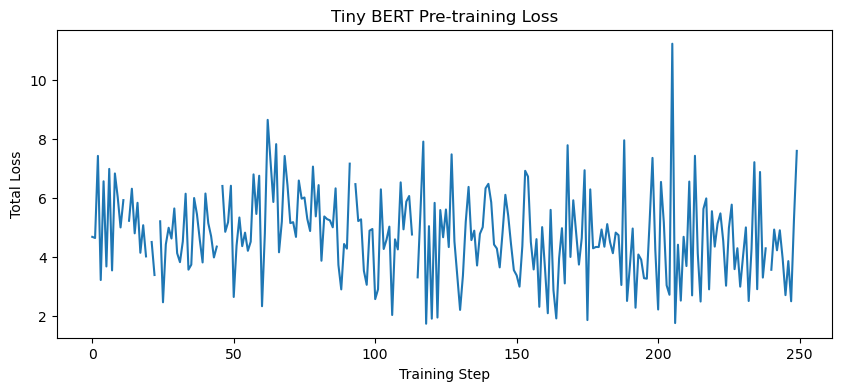

In [47]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Setup Model and Dataset
model = BertForPreTraining(config)
dataset = BertPretrainingDataset(EMOJI_CORPUS, TOKEN_TO_ID, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Loss Functions
nsp_loss_fn = nn.CrossEntropyLoss() # For NSP, which is a simple classifier
mlm_loss_fn = nn.CrossEntropyLoss(ignore_index=-100) # For MLM, which returns logits

# Learning Rate (with warm up, meaning that learning rate starts lower and increases up to its fixed value)
WARMUP_STEPS = 10
LEARNING_RATE = 1e-4
def lr_lambda(current_step):
    """Linear warmup function"""
    if current_step < WARMUP_STEPS:
        # Increase LR linearly from 0 to 1.0
        return float(current_step) / float(max(1, WARMUP_STEPS))
    # After warmup, LR is constant (1.0 * LEARNING_RATE)
    return 1.0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-6)

print("Starting training...")
model.train() # Put the model in "training" mode (enables dropout, etc.)

# ====== TRAINING LOOP ======
num_train_steps = 5000
loss_history = []
for i, batch in enumerate(dataloader):
    if i >= num_train_steps: break

    input_ids      = batch["input_ids"] # The embedding of the already concatenated (A, B) pair
    token_type_ids = batch["token_type_ids"] # Separates A from B (from padding)
    attention_mask = batch["attention_mask"] # Mask for ignoring padding during attention
    mlm_labels     = batch["mlm_labels"] # The true labels for the masked tokens
    nsp_label      = batch["nsp_label"] # 1 = NotNext, 0 = IsNext

    optimizer.zero_grad()

    # Run the Model on the batch
    mlm_logits, nsp_logits, attentions = model(input_ids, token_type_ids, attention_mask)

    # Calculate the two losses for the entire batch
    loss_mlm = mlm_loss_fn(
        mlm_logits.view(-1, config["vocab_size"]), # (batch_size*max_len, vocab_size)
        mlm_labels.view(-1)                        # (batch_size*max_len)
    )
    loss_nsp = nsp_loss_fn(
        nsp_logits, # (batch_size, 2)
        nsp_label   # (batch_size)
    )

    # The final loss is just the sum of the two!
    total_loss = loss_mlm + loss_nsp

    # Gradient and Backpropagation
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    loss_history.append(total_loss.item())
    if (i + 1) % 50 == 0:
        print(f"Step {i+1:03d}/{num_train_steps} | Total Loss: {total_loss.item():.4f} (MLM: {loss_mlm.item():.4f}, NSP: {loss_nsp.item():.4f})")

print("\n--- Training Complete ---")

# --- 5. Plot the Loss ---
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Tiny BERT Pre-training Loss")
plt.xlabel("Training Step")
plt.ylabel("Total Loss")
plt.show()